# Technical Report

## Introduction

In education platform, students can answer questions from multiple problem sets to enhance their knowledge. But which problem should the student attempt is an interesting problem. With the rise of machine learning, student's learning progress can be facilitated using knowledge tracing models. For knowledge tracing task, given the list of previous student's performance and interaction with the education platform, the machine learning model needs to predict the performance of student in the future (the probability that user can answer the question correctly). 

This application is useful, as it can be used to provide guidance for the user: we could build a recommender that suggests new problems for users (problems that are not too hard or not too easy for the user). We can also identify the knowledge area that users struggle in.

In this report, I would like to describe my attempt for this knowledge tracing task. This includes: Explanation of the chosen model, implementation details, model evaluation, and the demo website.

## Literature Review

Previous student's performance can be written as $\mathbf{X} = (\mathbf{x_1}, \mathbf{x_2}, ..., \mathbf{x_t})$ where $\mathbf{x_i} = (e_i, r_i)$, where $e_i$ is the question that the student attempts and $r_i$ is the corresponding correctness of student's answer.

We would like to calculate $P(r_{t + 1} = 1 | e_{t + 1}, \mathbf{X})$

Some previous attempts on this problem:
- Bayesian Knowledge Tracing: This approach use Hidden Markov Model to predict the performance of students. The main issue of this approach is that it oversimplify the knowledge state of students (1 being fulfilled and 0 being not fulfilled, there is no state in between)
- Deep Knowledge Tracing: This approach solves the previous problem of knowledge state expression. However, as it is based on Recurrent Neural Network, there are pitfalls of this approach: complex training procedures, poor performance for long sequence of $\mathbf{X}$, cannot process in parallel, etc. These are common problems of RNNs.

The problem of RNN can be solved by using attention mechanism, the popular method that is used in Transformer and GPT. Attention-based model allows: 
- Parallel processing
- Perform well on long sequence

For this problem, performing well on long sequence is important because we need a long history of student's performance to construct the knowledge state

## Model selection

I use SAKT model from this paper: https://arxiv.org/pdf/1907.06837.pdf

This model uses attention-based mechanism and achieved state-of-the-art performance on ASSISTments2015 dataset.

For the detailed architecture of the model, please visit part 2 of the paper.

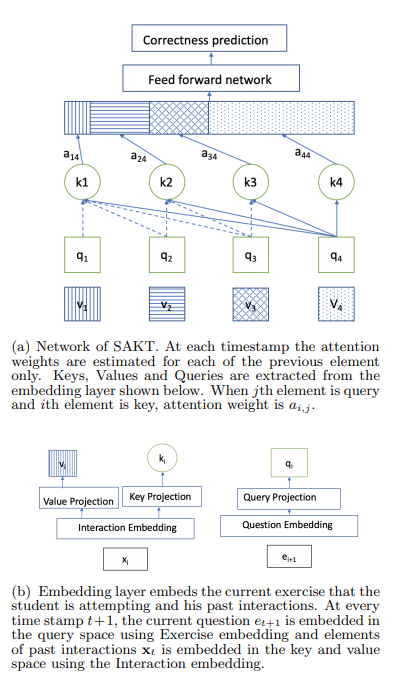

## Evaluation and discussion

After training, the model achieves:
- 0.71 AUC score, 0.14 points less than shown in the paper
- Accuracy: 80%
- precision=[0.58610272 0.80557474]
- recall=[0.1134656  0.97865174]
- fscore=[0.19012439 0.88371866]

The low AUC score, in comparison to the paper, suggests further analysis of the model to identify potential bugs.

# Implementation

## Data exploration

#### Loading data

In [1]:
import pandas as pd
data_csv = pd.read_csv('./data/data-2015.csv')
data_csv.head()

,user_id,log_id,sequence_id,correct
0,50121,167478035,7014,0.0
1,50121,167478043,7014,1.0
2,50121,167478053,7014,1.0
3,50121,167478069,7014,1.0
4,50964,167478041,7014,1.0


#### Data Description

The data file `data-2015.csv` is the ASSISTments dataset taken from: https://sites.google.com/site/assistmentsdata/datasets/2015-assistments-skill-builder-data. This dataset records the process of students answering questions in problem sets and their performance. The platform being used to collect data is: https://new.assistments.org/

Each row of the dataset contains the information of one student answering one question in a particular problem set.

- `user_id`: The id number assigned to each students. Each student has one unique id.
- `log_id`: The unique log id appeared in the database when the student answer current question. The larger log id is, the later the question was answered.
- `sequence_id`: The id of the problem sets that the question is in.
- `correct`: The correctness of the student's answer. It ranges from 0.0 to 1.0, where 0.0 means that the student answered incorrectly on the first attempt and 1.0 means that the student answered correctly on the first attempt. There may be values in between the range, however, for this current model, we only focus on the correct values of 0 and 1.

#### Data analysis

In [2]:
data_csv.describe()

,user_id,log_id,sequence_id,correct
count,708631.000000,7.086310e+05,708631.000000,708631.000000
mean,296232.978276,1.695323e+08,22683.474821,0.725502
std,48018.650247,3.608096e+06,41593.028018,0.437467
min,50121.000000,1.509145e+08,5898.000000,0.000000
25%,279113.000000,1.660355e+08,7020.000000,0.000000
50%,299168.000000,1.704579e+08,9424.000000,1.000000
75%,335647.000000,1.723789e+08,14442.000000,1.000000
max,362374.000000,1.754827e+08,236309.000000,1.000000


The dataset includes **708631 rows**.

In [3]:
print('Part of missing values for every column')
print(data_csv.isnull().sum() / len(data_csv))

Part of missing values for every column
user_id        0.0
log_id         0.0
sequence_id    0.0
correct        0.0
dtype: float64


As the data includes no missing values, we do not have to handle missing values

In [4]:
print('The number of unique values for every column')
print(data_csv.nunique())

The number of unique values for every column
user_id         19917
log_id         708631
sequence_id       100
correct            11
dtype: int64


The dataset records 19917 students answering 100 problem sets. Each row has one unique `log_id`. Lastly, there are multiple values of `correct`, however we only focus on the value of 0 and 1.

In [5]:
print('Correlation between columns')
print(data_csv.corr())

Correlation between columns
              user_id    log_id  sequence_id   correct
user_id      1.000000  0.515198    -0.040369  0.028428
log_id       0.515198  1.000000    -0.009621  0.054341
sequence_id -0.040369 -0.009621     1.000000 -0.069912
correct      0.028428  0.054341    -0.069912  1.000000


There are little correlation from other columns to the `correct` column

In [6]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for regression model using 'rating' as response variable
y, X = dmatrices('correct ~ user_id+log_id+sequence_id', data=data_csv, return_type='dataframe')
#create DataFrame to hold VIF values
vif_df = pd.DataFrame()
vif_df['variable'] = X.columns

#calculate VIF for each predictor variable
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

#view VIF for each predictor variable
print(vif_df)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


      variable       VIF
0    Intercept  0.000000
1      user_id  1.363667
2       log_id  1.361571
3  sequence_id  1.001803


The multicollinearity is not present in this dataset as VIF is smaller than 5

## Data preprocessing

In [7]:
import numpy as np

data_csv = data_csv.rename(columns={'sequence_id': "item_id"})
data_csv["skill_id"] = data_csv["item_id"]
data_csv["timestamp"] = np.zeros(len(data_csv), dtype=np.int64)
data_csv.head()

,user_id,log_id,item_id,correct,skill_id,timestamp
0,50121,167478035,7014,0.0,7014,0
1,50121,167478043,7014,1.0,7014,0
2,50121,167478053,7014,1.0,7014,0
3,50121,167478069,7014,1.0,7014,0
4,50964,167478041,7014,1.0,7014,0


In [8]:
data_csv = data_csv[data_csv["correct"].isin([0, 1])]
data_csv["correct"] = data_csv["correct"].astype(np.int32)
data_csv.describe()

,user_id,log_id,item_id,correct,skill_id,timestamp
count,683801.000000,6.838010e+05,683801.000000,683801.000000,683801.000000,683801.0
mean,294948.812122,1.693978e+08,22753.185753,0.731761,22753.185753,0.0
std,48033.447912,3.594528e+06,41869.791331,0.443043,41869.791331,0.0
min,50121.000000,1.509145e+08,5898.000000,0.000000,5898.000000,0.0
25%,278695.000000,1.659241e+08,7020.000000,0.000000,7020.000000,0.0
50%,295262.000000,1.703996e+08,9424.000000,1.000000,9424.000000,0.0
75%,333872.000000,1.721740e+08,14442.000000,1.000000,14442.000000,0.0
max,362374.000000,1.754827e+08,236309.000000,1.000000,236309.000000,0.0


In [9]:
data_csv = data_csv.groupby("user_id").filter(lambda x: len(x) >= 10)
data_csv = data_csv[~data_csv["skill_id"].isnull()]
data_csv["user_id"] = np.unique(data_csv["user_id"], return_inverse=True)[1]
data_csv["item_id"] = np.unique(data_csv["item_id"], return_inverse=True)[1]
data_csv["skill_id"] = np.unique(data_csv["skill_id"], return_inverse=True)[1]
data_csv.head()

,user_id,log_id,item_id,correct,skill_id,timestamp
17,0,167477835,92,0,92,0
18,0,167477856,92,0,92,0
19,0,167477877,92,1,92,0
20,0,167477884,92,0,92,0
21,0,167477890,92,1,92,0


For the sake of simplicity, I want to re-structure the dataset as following:

- Each row corresponds to one students
- The user_id is discarded to avoid overfitting
- Each row has two columns: The first column includes the list of questions that the student took. The second column includes the result of student's answer respectively. The questions are sorted in chronological order

In [11]:
#convert list of sequence_ids into string
def convert(list):
    s = [str(i) for i in list]
    res = ",".join(s)
    return(res)
#sort data by log_id
data_csv = data_csv.sort_values(by=["log_id"])

group = data_csv.groupby("user_id")
preprocessed_data = pd.DataFrame(columns=["sequence_ids", "correctness"])
n_user = len(group)
for user_id in range(n_user):
    user_data = group.get_group(user_id)
    sequence_ids = user_data["item_id"].values
    correctness = user_data["correct"].values
    preprocessed_data.loc[user_id] = [convert(sequence_ids), convert(correctness)]
#write preprocessed data to csv file
preprocessed_data.to_csv("./data/preprocessed_data.csv", sep="\t", index=False)
#separate preprocessed data into train and test sets
train_data = preprocessed_data[: int(0.8 * len(preprocessed_data))]
test_data = preprocessed_data[int(0.8 * len(preprocessed_data)) :]
#write train and test data to csv files
train_data.to_csv("./data/assist2015_train.csv", sep="\t", index=False, header=False)
test_data.to_csv("./data/assist2015_test.csv", sep="\t", index=False, header=False)

## Model implementation

Disclaimer: The implementation of this model heavily relies on https://github.com/jdxyw/deepKT/tree/master. Due to time constraint, I decided to only understand what the code does, instead of implementing from the beginning

#### Model arguments

In [27]:
class args():
    def __init__(self):
        self.learning_rate = 0.001
        self.batch_size = 64
        self.epoch = 15
        self.dropout = 0.2
        self.num_skill = 100
        self.embed_dim = 200
        self.num_heads = 5
        self.num_worker = 0
args = args()


#### Dataset Module

Let's create our Dataset that subclasses `torch.utils.data.Dataset`

In [15]:
import torch.nn.utils
import numpy as np

class SAKTDataset(torch.utils.data.Dataset):
    
    """
    __init__ function:
    df: the preprocessed data.
    n_skill: the number of unique sequence_id (for this dataset, 100).
    max_len: the fixed length of each input sequence.
    """
    def __init__(self, df, n_skill, max_len=200):
        super(SAKTDataset, self).__init__()
        self.df = df
        self.n_skill = n_skill
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    """__getitem__ function: this function is called when you index a SAKTDataset object.
    idx: the index of the data point.
    return: a tuple of four tensors: the encoded question id + correct answer, 
            the question id, the correct answer, and the mask. All are padded to the same length.
    """
    def __getitem__(self, idx):
        qids = self.df[0][idx].split(",")
        correct = self.df[1][idx].split(",")

        #if the length of the sequence is greater than max_len, only use the last max_len elements
        if len(qids) > self.max_len:
            qids = qids[-self.max_len :]
            correct = correct[-self.max_len :]

        qids = np.array(list(map(int, qids)))
        correct = np.array(list(map(int, correct)))

        #encode question id + correct answer into one number
        qa = qids + correct * self.n_skill

        #create paddings
        q = np.ones(self.max_len, dtype=int) * self.n_skill
        qa2 = np.ones(self.max_len, dtype=int) * (self.n_skill * 2 + 1)
        correct2 = np.ones(self.max_len, dtype=int) * -1
        mask = np.zeros(self.max_len, dtype=int)

        #fill in the paddings
        q[: len(qids)] = qids
        qa2[: len(qa)] = qa
        correct2[: len(correct)] = correct
        mask[: len(qa)] = np.ones(len(qa), dtype=int)

        return (
            torch.cat(
                (torch.LongTensor([2 * self.n_skill]), torch.LongTensor(qa2[:-1]))
            ),
            torch.LongTensor(q),
            torch.LongTensor(correct2),
            torch.LongTensor(mask),
        )


#### Model

In [16]:
# -*- coding:utf-8 -*-

import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_fscore_support,
    accuracy_score,
)

def train_epoch(model, train_iterator, optim, criterion, device="cpu"):
    model.train()

    #iterate over each batch of the dataset (train_iterator is the Dataloader object)
    for i, (qa, qid, labels, mask) in enumerate(train_iterator):
        qa, qid, labels, mask = (
            qa.to(device),
            qid.to(device),
            labels.to(device),
            mask.to(device),
        ) #move data to device (cpu or gpu)

        optim.zero_grad() #reset the gradients to zero
        logits, _ = model(qid, qa) #call the forward function of the model
        loss = criterion(logits, labels, qid, mask, device=device) #calculate the loss
        loss.backward() #backpropagation
        optim.step() #update the parameters
        
def future_mask(seq_length):
    #create a mask that prevents the model from attending to future steps
    mask = np.triu(np.ones((seq_length, seq_length)), k=1).astype("bool")
    return torch.from_numpy(mask)


def eval_epoch(model, test_iterator, criterion, eval_func, device="cpu"):
    #set the model to evaluation mode
    model.eval()
    eval_loss = []
    preds, binary_preds, targets = [], [], []
    for i, (qa, qid, labels, mask) in enumerate(test_iterator):
        qa, qid, labels, mask = (
            qa.to(device),
            qid.to(device),
            labels.to(device),
            mask.to(device),
        )
        
        #do not calculate the gradients
        with torch.no_grad():
            logits, _ = model(qid, qa)

        loss = criterion(logits, labels, qid, mask, device=device)
        eval_loss.append(loss.detach().item())

        mask = mask.eq(1)
        pred, binary_pred, target = eval_func(logits, qid, labels, mask)
        preds.append(pred)
        binary_preds.append(binary_pred)
        targets.append(target)

    #concatenate the results from all batches
    preds = np.concatenate(preds)
    binary_preds = np.concatenate(binary_preds)
    targets = np.concatenate(targets)

    #auc is the area under the ROC curve (receiver operating characteristic curve). 
    #It is a metric for binary classification. Larger auc means better performance.
    auc_value = roc_auc_score(targets, preds)
    #accuracy is the number of correct predictions divided by the total number of predictions.
    accuracy = accuracy_score(targets, binary_preds)
    #precision is the number of true positives divided by the number of true positives and false positives.
    #recall is the number of true positives divided by the number of true positives and false negatives.
    precision, recall, f_score, _ = precision_recall_fscore_support(
        targets, binary_preds
    )
    #positive rate is the number of positive labels divided by the total number of labels.
    #for this dataset, pos_rate is high
    pos_rate = np.sum(targets) / float(len(targets))
    print(
        "auc={0}, accuracy={1}, precision={2}, recall={3}, fscore={4}, pos_rate={5}".format(
            auc_value, accuracy, precision, recall, f_score, pos_rate
        )
    )

class FFN(nn.Module):
    def __init__(self, state_size=200, dropout=0.2):
        super(FFN, self).__init__()
        self.state_size = state_size
        self.dropout = dropout
        self.lr1 = nn.Linear(self.state_size, self.state_size)
        self.relu = nn.ReLU()
        self.lr2 = nn.Linear(self.state_size, self.state_size)
        self.dropout = nn.Dropout(self.dropout)

    def forward(self, x):
        x = self.lr1(x)
        x = self.relu(x)
        x = self.lr2(x)
        return self.dropout(x)

class SAKTModel(nn.Module):
    def __init__(
        self, n_skill, embed_dim, dropout, num_heads=4, max_len=64, device="cpu"
    ):
        super(SAKTModel, self).__init__()
        self.n_skill = n_skill
        self.q_embed_dim = embed_dim
        self.qa_embed_dim = embed_dim
        self.pos_embed_dim = embed_dim
        self.embed_dim = embed_dim
        self.dropout = dropout
        self.num_heads = num_heads
        self.max_len = max_len
        self.device = device

        self.q_embedding = nn.Embedding(
            n_skill + 1, self.q_embed_dim, padding_idx=n_skill
        )
        self.qa_embedding = nn.Embedding(
            2 * n_skill + 2, self.qa_embed_dim, padding_idx=2 * n_skill + 1
        )
        self.pos_embedding = nn.Embedding(self.max_len, self.pos_embed_dim)

        self.multi_attention = nn.MultiheadAttention(
            embed_dim=self.embed_dim, num_heads=self.num_heads, dropout=self.dropout
        )

        self.key_linear = nn.Linear(self.embed_dim, self.embed_dim)
        self.value_linear = nn.Linear(self.embed_dim, self.embed_dim)
        self.query_linear = nn.Linear(self.embed_dim, self.embed_dim)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim)
        self.dropout_layer = nn.Dropout(self.dropout)
        self.ffn = FFN(self.embed_dim)
        self.pred = nn.Linear(self.embed_dim, 1, bias=True)

    def forward(self, q, qa):
        qa = self.qa_embedding(qa)
        pos_id = torch.arange(qa.size(1)).unsqueeze(0).to(self.device)
        pos_x = self.pos_embedding(pos_id)
        qa = qa + pos_x # Add positional embedding
        q = self.q_embedding(q)

        q = q.permute(1, 0, 2)
        qa = qa.permute(1, 0, 2)

        attention_mask = future_mask(q.size(0)).to(self.device)
        attention_out, _ = self.multi_attention(q, qa, qa, attn_mask=attention_mask)
        attention_out = self.layer_norm1(attention_out + q)
        attention_out = attention_out.permute(1, 0, 2)

        x = self.ffn(attention_out)
        x = self.dropout_layer(x)
        x = self.layer_norm2(x + attention_out)
        x = self.pred(x)

        return x.squeeze(-1), None

#### Training model


In [28]:
import sys

sys.path.insert(0, "..")

import torch
import torch.optim
import utils
from loss import SAKTLoss
from torch.utils.data import DataLoader
import pandas as pd
import logging

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)


def run():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_df = pd.read_csv("./data/assist2015_train.csv",
                           header=None,
                           sep='\t')
    test_df = pd.read_csv("./data/assist2015_test.csv", header=None, sep='\t')

    train = SAKTDataset(train_df, args.num_skill, max_len=128)
    test = SAKTDataset(test_df, args.num_skill, max_len=128)
    train_dataloader = DataLoader(train,
                                  batch_size=args.batch_size,
                                  num_workers=args.num_worker,
                                  shuffle=True)
    test_dataloader = DataLoader(test,
                                 batch_size=args.batch_size * 2,
                                 num_workers=args.num_worker,
                                 shuffle=False)

    sakt = SAKTModel(args.num_skill, args.embed_dim, args.dropout, args.num_heads, device=device, max_len=128)

    optimizer = torch.optim.Adam(sakt.parameters(), lr=args.learning_rate)
    loss_func = SAKTLoss()

    sakt.to(device)
    loss_func.to(device)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    for epoch in range(args.epoch):
        utils.train_epoch(sakt, train_dataloader, optimizer, loss_func,
                                 device)
        utils.eval_epoch(sakt, test_dataloader, loss_func, utils.sakt_eval, device)
        scheduler.step()
        
    #save the weights of the model
    torch.save(sakt.state_dict(), './saved/sakt_weights.pth')
run()

auc=0.7167315136552093, accuracy=0.7966361579888882, precision=[0.58610272 0.80557474], recall=[0.1134656  0.97865174], fscore=[0.19012439 0.88371866], pos_rate=0.7896226325802391
auc=0.7298259036990143, accuracy=0.7976678371650592, precision=[0.58985201 0.80740763], recall=[0.12552301 0.97674586], fscore=[0.20699633 0.8840406 ], pos_rate=0.7896226325802391
auc=0.7281364515559224, accuracy=0.7978855309361779, precision=[0.57743481 0.81031035], recall=[0.14644351 0.97144775], fscore=[0.2336348  0.88359263], pos_rate=0.7896226325802391


KeyboardInterrupt: 

## Inference

To predict the accuracy of the next question, you can use query function below

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


#load the model sakt_all.pth
MODEL_PATH = "./saved/sakt_weights.pth"
model = SAKTModel(args.num_skill, args.embed_dim, args.dropout, args.num_heads, max_len=128)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

train_df = pd.read_csv("./data/assist2015_train.csv",
                           header=None,
                           sep='\t')
train = SAKTDataset(train_df, 100, max_len=128)
train_dataloader = DataLoader(train,
                            batch_size=args.batch_size,
                            num_workers=args.num_worker,
                            shuffle=True)

def query(prev_qid, prev_correct, cur_qid):
    prev_qid = np.array(prev_qid)
    prev_correct = np.array(prev_correct)
    qa = prev_qid + 100 * prev_correct
    padding_qa = np.ones(128, dtype=np.int8) * 201
    padding_qa[:len(qa)] = qa
    qid = prev_qid.copy().tolist()
    qid.append(cur_qid)
    qid = np.array(qid)
    padding_qid = np.ones(128, dtype=np.int8) * 100
    padding_qid[:len(qid)] = qid 
    padding_qa = torch.LongTensor(np.array([padding_qa]))
    padding_qid = torch.LongTensor(np.array([padding_qid]))
    with torch.no_grad():
        logits, _ = model(padding_qid, padding_qa)
    logits = torch.sigmoid(logits)
    prob = logits[0][len(prev_qid)].detach().numpy()
    return int(prob * 100)


## Evaluation

The model is evaluated with the test set after every epoch. The metrics being used are:
- AUC: area under the ROC curve
- Accuracy
- Precision
- Recall

In [1]:
def eval_epoch(model, test_iterator, criterion, eval_func, device="cpu"):
    model.eval()

    eval_loss = []
    preds, binary_preds, targets = [], [], []
    for i, (qa, qid, labels, mask) in enumerate(test_iterator):
        qa, qid, labels, mask = (
            qa.to(device),
            qid.to(device),
            labels.to(device),
            mask.to(device),
        )

        with torch.no_grad():
            logits, _ = model(qid, qa)

        loss = criterion(logits, labels, qid, mask, device=device)
        eval_loss.append(loss.detach().item())

        mask = mask.eq(1)

        pred, binary_pred, target = eval_func(logits, qid, labels, mask)
        preds.append(pred)
        binary_preds.append(binary_pred)
        targets.append(target)

    preds = np.concatenate(preds)
    binary_preds = np.concatenate(binary_preds)
    targets = np.concatenate(targets)

    auc_value = roc_auc_score(targets, preds)
    accuracy = accuracy_score(targets, binary_preds)
    precision, recall, f_score, _ = precision_recall_fscore_support(
        targets, binary_preds
    )
    pos_rate = np.sum(targets) / float(len(targets))
    print(
        "auc={0}, accuracy={1}, precision={2}, recall={3}, fscore={4}, pos_rate={5}".format(
            auc_value, accuracy, precision, recall, f_score, pos_rate
        )
    )

## Website

The code of the Streamlit website is in the file `web.py`. You can try running it by using `streamlit run ./web.py`